In [52]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence
from signature.signature.stationary_signature import stationary_signature_from_path, G
from signature.signature.expected_signature import expected_signature, expected_stationary_signature
from scipy.optimize import minimize

green = "#5b6c64"
copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[green, copper, "#322B4D", "#28BC9C", "#71074E"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%time
ta = TensorAlgebra(dim=2)

Compiling...
Compilation finished.
CPU times: user 2min 4s, sys: 201 ms, total: 2min 4s
Wall time: 2min 4s


Text(0.5, 1.0, 'Driving Brownian motion W')

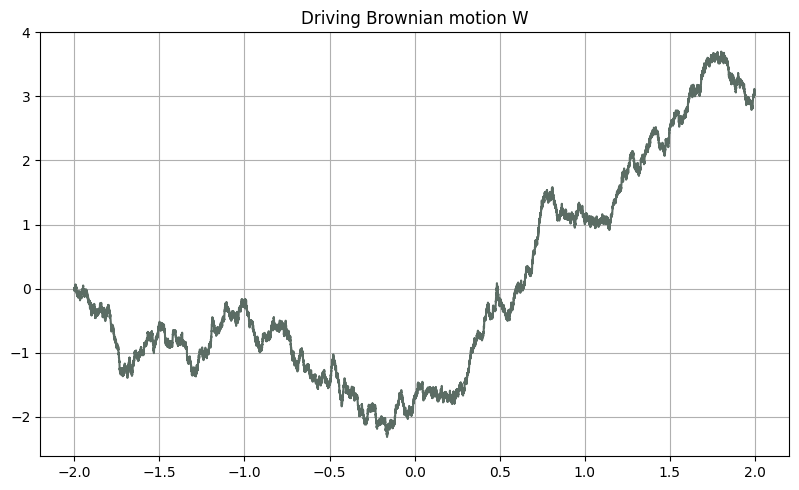

In [73]:
points_per_day = 20
T = 2

t_grid = np.linspace(-T, T, points_per_day * 2 * T * 365 + 1)

rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

fig, ax = plt.subplots()

ax.plot(t_grid, W)
ax.set_title("Driving Brownian motion W")


## OU representation

$$
d\sigma_t = \kappa (\theta - \sigma_t) dt + dW_t
$$

In [74]:
kappa = 15
theta = 0
nu = 1

ou = np.zeros_like(W)
ou[0] = theta
dt = np.diff(t_grid)
dW = np.diff(W)
for i in range(ou.size - 1):
    ou[i + 1] = ou[i] + kappa * (theta - ou[i]) * dt[i] + nu * dW[i]

Text(0.5, 1.0, 'OU trajectory')

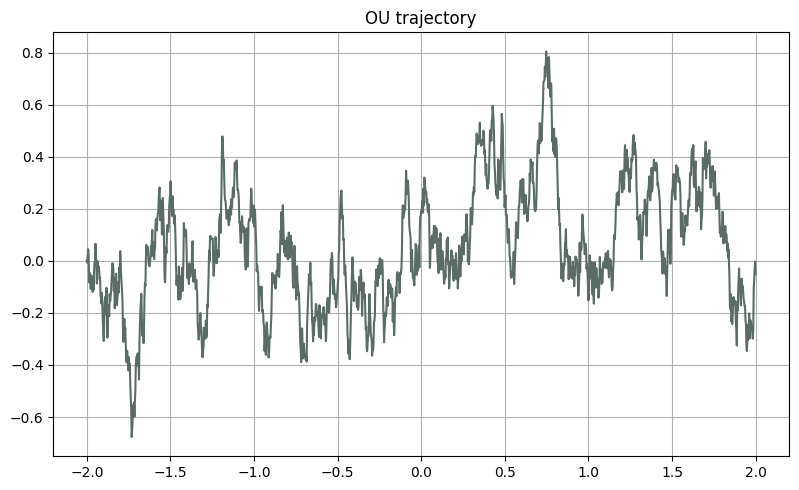

In [75]:
t_daily = t_grid[::points_per_day]
W_daily = W[::points_per_day]
ou_daily = ou[::points_per_day]

fig, ax = plt.subplots()
ax.plot(t_daily, ou_daily)
ax.set_title("OU trajectory")

In [76]:
path = np.vstack([t_daily, W_daily]).T
path_pos = np.vstack([t_daily[t_daily >= 0], W_daily[t_daily >= 0]]).T

%%time

N = 10
W_sig = ta.path_to_sequence(path=path_pos, trunc=N)

In [161]:
%%time

N = 10
lam = 5
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

In [162]:
e0 = ta.from_dict({"": 1}, trunc=N)
e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)
e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)
e221 = ta.from_dict({"221": 1}, trunc=N)

In [163]:
def repr_operator(ell, lam, mu, sigma, x0=0):
    return e0 * x0 + (G(ell) * lam + mu(ell)).tensor_prod_word("1") + (sigma(ell)).tensor_prod_word("2")

mu_ou = lambda ell: ell * (-kappa)
sigma_ou = lambda ell: e0 * 1

In [164]:
l_kappa_iter = e0 * 0
for i in range(N + 1):
    l_kappa_iter = repr_operator(l_kappa_iter, lam, mu_ou, sigma_ou)
ta.print(l_kappa_iter)

1.0*2 + -10.0*21 + 50.0*211


In [165]:
green = "#5b6c64"
copper = "#B56246"

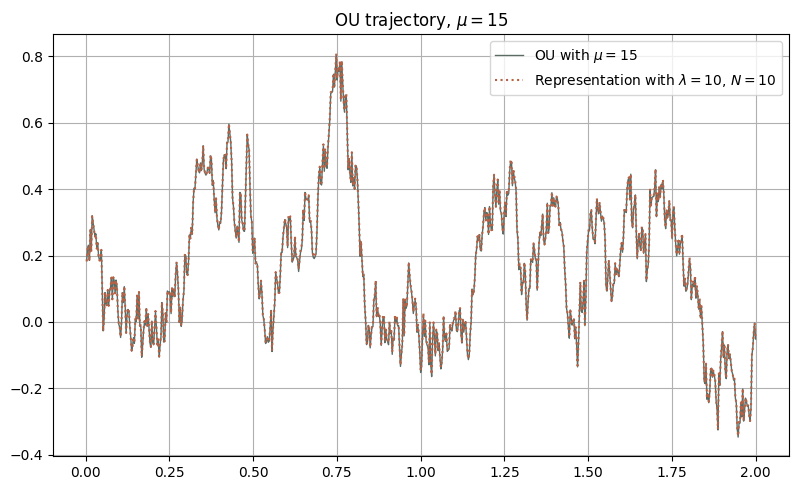

In [82]:
fig, ax = plt.subplots()
idx_start = 0
step = 500

# ax.plot(t_daily[t_daily >= 0][idx_start:idx_start+step], (SigS @ (Ø * theta + _2)).real[idx_start:idx_start+step], "b", lw=1)
ax.plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, lw=1, label=f"OU with $\mu={kappa}$")
ax.plot(t_daily[t_daily >= 0], (SigS @ (Ø * theta + l_kappa_iter)).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$", lw=1.5)
ax.set_title(f"OU trajectory, $\mu={kappa}$")
ax.legend()

In [83]:
s0 = ou_daily[t_daily >= 0][0]

In [95]:
l_kappa_iter_lam0 = e0 * 0
for i in range(N + 1):
    l_kappa_iter_lam0 = repr_operator(l_kappa_iter_lam0, 0, mu_ou, sigma_ou, x0=s0)
ta.print(l_kappa_iter_lam0)

0.18466763510915968*∅ + -2.7700145266373952*1 + 1.0*2 + 41.55021789956093*11 + -15.0*21 + -623.2532684934139*111 + 225.0*211 + 9348.799027401208*1111 + -3375.0*2111 + -140231.98541101813*11111 + 50625.0*21111 + 2103479.781165272*111111 + -759375.0*211111 + -31552196.71747908*1111111 + 11390625.0*2111111 + 473282950.76218617*11111111 + -170859375.0*21111111 + -7099244261.432793*111111111 + 2562890625.0*211111111 + 106488663921.49188*1111111111 + -38443359375.0*2111111111


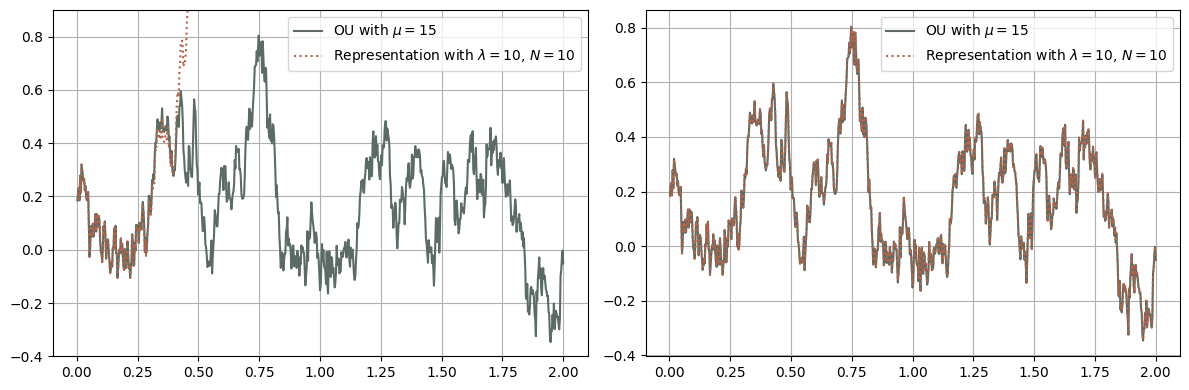

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

idx_start = 0
step = 500

ax[0].plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, label=f"OU with $\mu={kappa}$")
ax[0].plot(t_daily[t_daily >= 0], (W_sig @ l_kappa_iter_lam0).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$")
ax[0].set_ylim([-0.4, 0.9])
ax[0].legend(loc=1)

ax[1].plot(t_daily[t_daily >= 0], ou_daily[t_daily >= 0], color=green, label=f"OU with $\mu={kappa}$")
ax[1].plot(t_daily[t_daily >= 0], (SigS @ (Ø * theta + l_kappa)).real, ":", color=copper, label=f"Representation with $\lambda={lam}$, $N={N}$")
ax[1].legend(loc=1)

fig.tight_layout()
fig.savefig("signature_ou_representation.pdf", format="pdf", transparent=True)

### Langevin dynamics

$$
dX_t = - \mu X_t^p dt + dW_t
$$

In [ ]:
e0 = ta.from_dict({"": 1}, trunc=N)
e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)
e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)
e221 = ta.from_dict({"221": 1}, trunc=N)

In [257]:
mu = 50
p = 5

In [258]:
X = np.zeros_like(W)
X[0] = 0
dt = np.diff(t_grid)
dW = np.diff(W)
for i in range(X.size - 1):
    X[i + 1] = X[i] -mu * (X[i]**p) * dt[i] + dW[i]

X_daily = X[::points_per_day]

In [259]:
mu_langevin = lambda l: l.shuffle_pow(p) * (-mu)
sigma_langevin = lambda l: e0 * 1

In [260]:
%%time

N = 10
lam = 30
SigS = stationary_signature_from_path(path=path, trunc=N, t_grid=t_daily, lam=lam)

CPU times: user 4.64 s, sys: 4.1 ms, total: 4.64 s
Wall time: 4.63 s


In [261]:
%%time

l_langevin_stat = e0 * 0
for i in range(N + 1):
    l_langevin_stat = repr_operator(l_langevin_stat, lam, mu_langevin, sigma_langevin)
ta.print(l_langevin_stat)
print(not bool(l_langevin_stat - repr_operator(l_langevin_stat, lam, mu_langevin, sigma_langevin)))

1.0*2 + 30.0*21 + 1800.0*211 + 162000.0*2111 + 19440000.0*21111 + 2916000000.0*211111 + -6000.0*222221 + 524880000000.0*2111111 + -180000.0*2122221 + -360000.0*2212221 + -540000.0*2221221 + -720000.0*2222121 + -1980000.0*2222211 + 110224800000000.0*21111111 + -10800000.0*21122221 + -16200000.0*21212221 + -21600000.0*21221221 + -27000000.0*21222121 + -70200000.0*21222211 + -32400000.0*22112221 + -43200000.0*22121221 + -54000000.0*22122121 + -140400000.0*22122211 + -64800000.0*22211221 + -81000000.0*22212121 + -210600000.0*22212211 + -108000000.0*22221121 + -280800000.0*22221211 + -577800000.0*22222111 + 2.6453952e+16*211111111 + -972000000.0*211122221 + -1296000000.0*211212221 + -1620000000.0*211221221 + -1944000000.0*211222121 + -4860000000.0*211222211 + -1944000000.0*212112221 + -2430000000.0*212121221 + -2916000000.0*212122121 + -7290000000.0*212122211 + -3240000000.0*212211221 + -3888000000.0*212212121 + -9720000000.0*212212211 + -4860000000.0*212221121 + -12150000000.0*212221211 + 

In [262]:
%%time

x0 = X_daily[t_daily >= 0][0]
l_langevin = e0 * 0
for i in range(N + 2):
    l_langevin = repr_operator(l_langevin, 0, mu_langevin, sigma_langevin, x0=x0)
ta.print(l_langevin)
print(not bool(l_langevin - repr_operator(l_langevin, lam, mu_langevin, sigma_langevin)))

0.001341200077165268*∅ + 1.0*2 + -1.4475446201680278e-06*221 + -0.005396452940964362*2221 + -8.047200462991608*22221 + -6000.0*222221 + 8.154077216332016e-06*2212221 + 5.377808068866592e-05*2221221 + 0.000180748711628693*2222121 + 0.0004504156938545304*2222211 + 0.008685267721008166*22122221 + 0.06948214176806533*22212221 + 0.2692432993512532*22221221 + 0.7491043409369544*22222121 + 1.715340374899113*22222211 + 32.378717645786175*222122221 + 194.27230587471703*222212221 + 679.9530705615098*222221221 + 1813.208188164026*222222121 + 4079.7184233690577*222222211 + -7.719399914458343e-07*2221222121 + -2.329439979615456e-06*2221222211 + -2.956588838029512e-06*2222122121 + -8.866204358861996e-06*2222122211 + 48283.20277794964*2222122221 + -1.1817973810408539e-06*2222211221 + -6.989420016195741e-06*2222212121 + -2.242010022658134e-05*2222212211 + 289699.2166676979*2222212221 + -1.4104563158034124e-05*2222221121 + -4.4797245051901444e-05*2222221211 + 1013947.2583369426*2222221221 + -8.06760058

StatSig RMSE:  0.43187908840165334


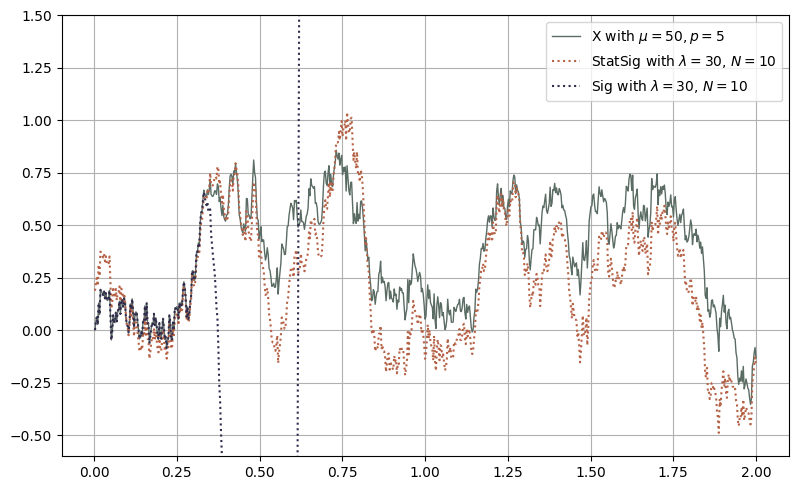

In [263]:
fig, ax = plt.subplots()
idx_start = 0
step = 500

ax.plot(t_daily[t_daily >= 0], X_daily[t_daily >= 0], lw=1, label=f"X with $\mu={mu}, p = {p}$")
ax.plot(t_daily[t_daily >= 0], (SigS @ l_langevin_stat).real, ":", label=f"StatSig with $\lambda={lam}$, $N={N}$")
ax.plot(t_daily[t_daily >= 0], (W_sig @ l_langevin).real, ":", label=f"Sig with $\lambda={lam}$, $N={N}$")
ax.set_ylim([-0.6, 1.5])
ax.legend()

print("StatSig RMSE: ", np.sqrt(np.mean(((SigS @ l_langevin_stat).real - X_daily[t_daily >= 0])**2)))

- Try regression ?